## Preliminares

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

from qiskit import Aer, QuantumCircuit, transpile
from qiskit.opflow import Z, I
from qiskit.utils import  algorithm_globals
from qiskit.algorithms.optimizers import SPSA

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_qsphere

from IPython.display import clear_output

from sklearn.model_selection import train_test_split,cross_val_score

algorithm_globals.random_seed = 42



from Aux_Data import plot_predicted, plot_area, plot_bloch_sphere
from QWNN import  quantum_weightless_neuron_ry
from quantum_encoding import angle_encoding
from Aux_QuantumML import get_opflow_qnn,apply_circuit, get_bloch_coordinates, get_statevector



In [2]:
normalization = np.pi
# Loading some example data
iris = datasets.load_iris()
X_all = iris.data[:, [2,3]]
Y_all = iris.target
X = np.array(X_all[50:150])
Y = np.array(Y_all[50:150])

# Randomly shuffle data and labels 
rnd = np.random.RandomState(42)
idx = rnd.permutation(len(Y))
X, Y = X[idx], Y[idx]

# Scale to the range (0, +1)
y01 = (Y - min(Y))
y01 = y01 // max(y01)

# Scale to the range (-1, +1)
minmax_scale = MinMaxScaler((0, normalization)).fit(X)
X = minmax_scale.transform(X)
y = 2 * y01 -1


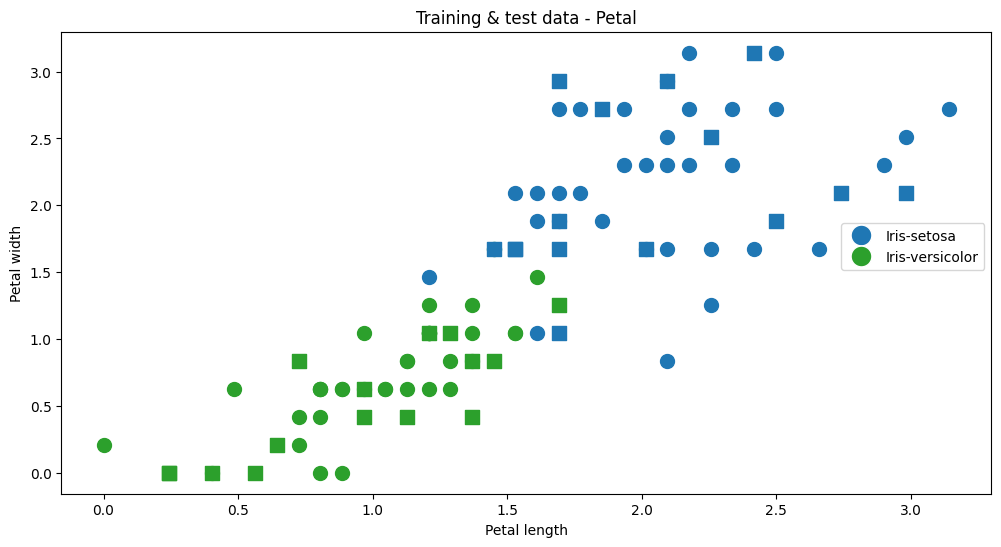

In [3]:
from Aux_Data import plot_sampled_data_petal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1, stratify=y)
plot_sampled_data_petal(training_features = X_train, training_labels = y_train, test_features= X_test, test_labels = y_test)

In [4]:
X

array([[1.69162681, 1.04719755],
       [2.0943951 , 1.67551608],
       [2.17494876, 2.72271363],
       [0.96664389, 0.41887902],
       [0.96664389, 0.62831853],
       [0.80553658, 0.62831853],
       [1.5305195 , 1.04719755],
       [2.49716339, 1.88495559],
       [0.40276829, 0.        ],
       [1.36941218, 0.83775804],
       [1.20830487, 1.04719755],
       [0.64442926, 0.20943951],
       [1.5305195 , 1.67551608],
       [1.69162681, 1.25663706],
       [2.0943951 , 2.93215314],
       [1.28885852, 1.04719755],
       [1.44996584, 1.67551608],
       [1.5305195 , 1.67551608],
       [0.80553658, 0.        ],
       [0.5638756 , 0.        ],
       [2.89993168, 2.30383461],
       [1.44996584, 1.67551608],
       [1.44996584, 0.83775804],
       [0.80553658, 0.41887902],
       [1.61107316, 1.04719755],
       [1.12775121, 0.83775804],
       [1.12775121, 0.41887902],
       [1.61107316, 1.88495559],
       [0.72498292, 0.83775804],
       [2.98048534, 2.0943951 ],
       [0.

## Circuito

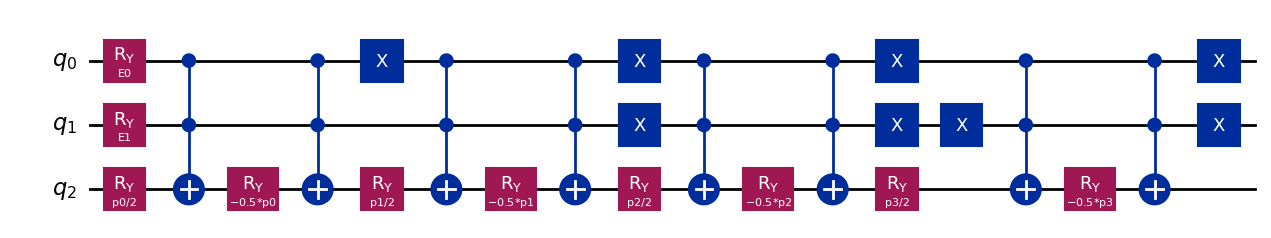

In [9]:
test = QuantumCircuit(3)
feature_map = angle_encoding(input_size=2)
test.append(feature_map, [0,1])
ansatz= quantum_weightless_neuron_ry(2)
test.append(ansatz, [0,1,2])
test.decompose().draw('mpl', style='iqx')

In [6]:
# callback function that draws a live plot when the .fit() method is called
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.figsize"] = (6, 4)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


In [11]:
hamiltonian = Z ^ I ^ I
qnn = get_opflow_qnn(test, feature_map, ansatz, hamiltonian)

## Treinamento

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
score_list = []
best_score = 0
best_clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
for i in range(3):
    print("Iteration ", i)
    clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    score_list.append(score)
    if(score>best_score):
        best_score = score
        best_clf = clf
print("Mean: ", np.mean(score_list))
print("Std: ", np.std(score_list))
print(best_score)
print(best_clf._fit_result.x)

Iteration  0
Iteration  1
Iteration  2
Mean:  1.0
Std:  0.0
1.0
[ 2.29442412e-03 -4.16999180e-01  1.90773581e+00  2.99072268e+00]


In [13]:
score_list

[1.0, 1.0, 1.0]

Wrong predicted: 0


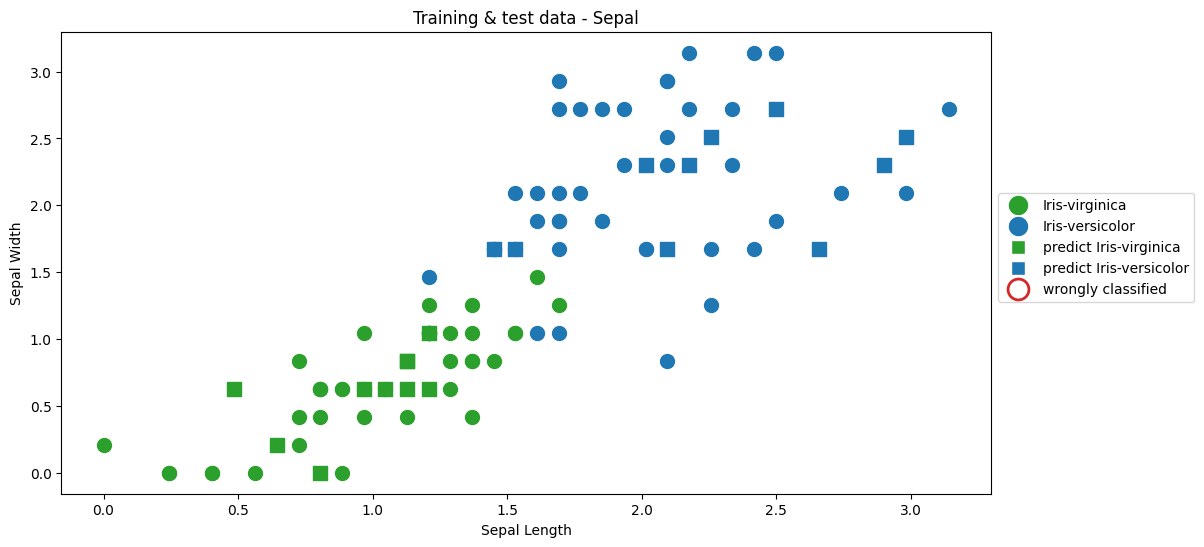

In [15]:
predicted = best_clf.predict(X_test)  
plot_predicted(2,3,X_train, y_train, X_test, y_test, predicted)

In [16]:
best_clf.save("models/neuron_spsa_iris-alt.model")

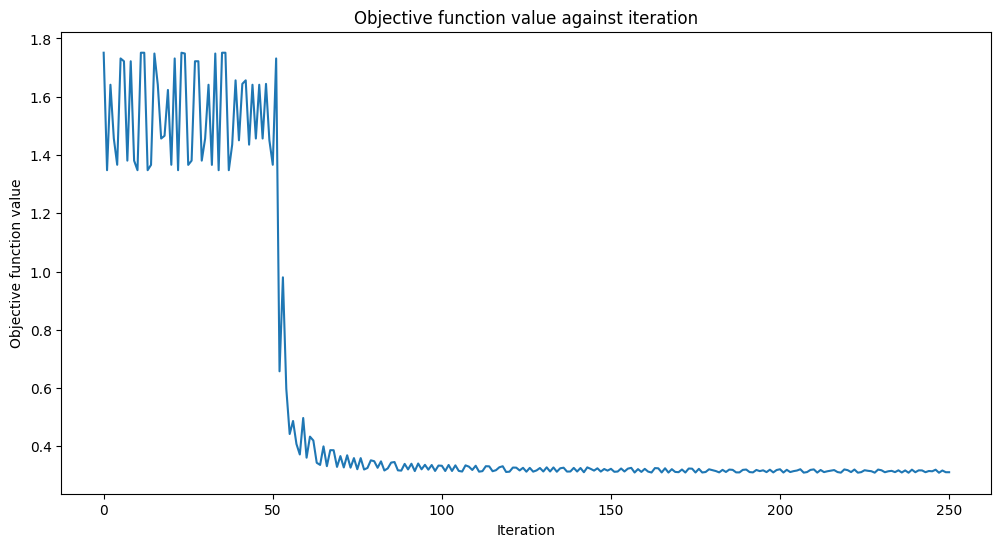

1.0

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer = SPSA(), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_test, y_test)

### Salvando o modelo

In [91]:
opflow_classifier.save("neuron_spsa_2pi.model")

## Plotando os valores previstos

Wrong predicted: 0


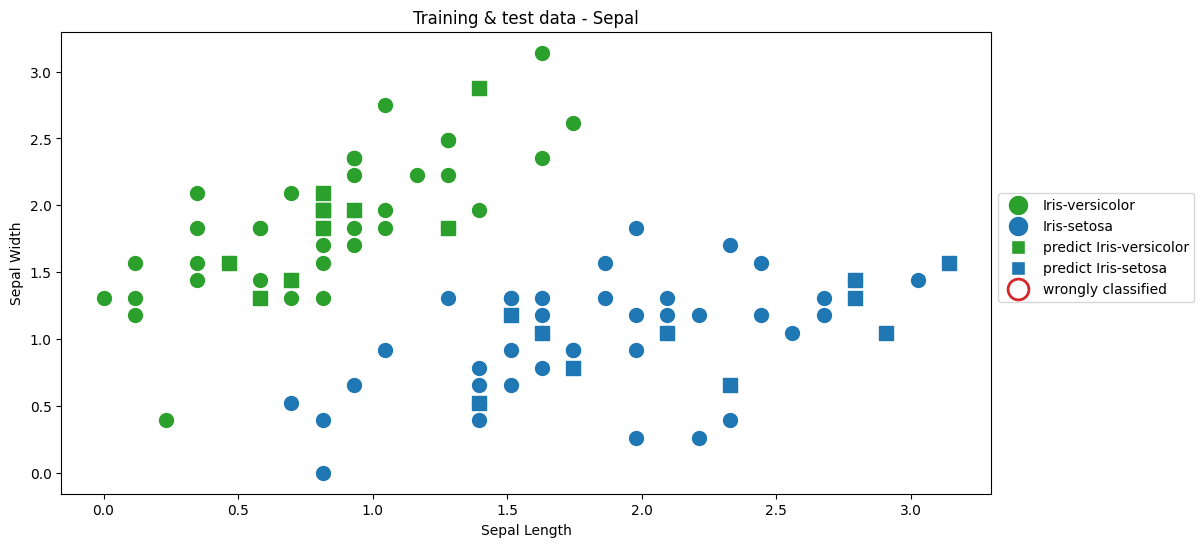

In [21]:
predicted = opflow_classifier.predict(X_test)  
plot_predicted(1,2,X_train, y_train, X_test, y_test, predicted)

Tentando ter ideia das regiões de decisão

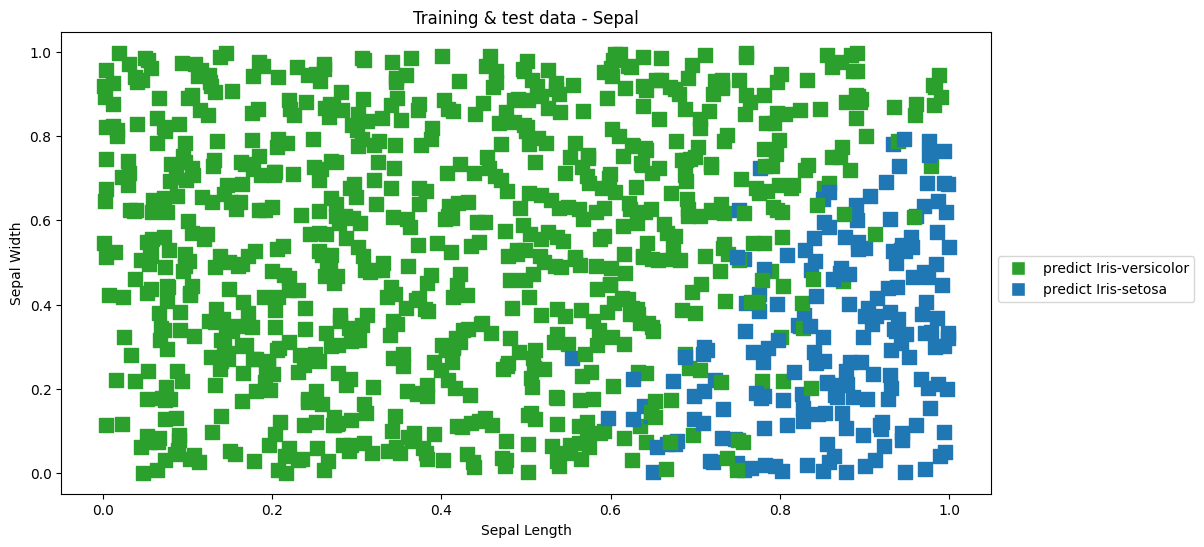

In [22]:
test2_col1 = np.random.uniform(low=0, high=1.0, size=(1000,))
test2_col2 = np.random.uniform(low=0, high=1.0, size=(1000,))
test2= np.vstack((test2_col2, test2_col1)).T
predicted = opflow_classifier.predict(test2)
plot_area(1,2, test2, predicted)

## Carregando modelo

In [2]:
#Para 4pi, utilizar 4pi-0.001
normalization = 2*np.pi
# Loading some example data
iris = datasets.load_iris()
X_all = iris.data[:, [0,1]]
Y_all = iris.target
X = np.array(X_all[:100])
Y = np.array(Y_all[:100])

# Randomly shuffle data and labels 
rnd = np.random.RandomState(42)
idx = rnd.permutation(len(Y))
X, Y = X[idx], Y[idx]

# Scale to the range (0, +1)
y01 = (Y - min(Y))
y01 = y01 // max(y01)

# Scale to the range (-1, +1)
minmax_scale = MinMaxScaler((0, normalization)).fit(X)
X = minmax_scale.transform(X)
y = 2 * y01 -1


In [8]:
X

array([[1.97803982, 0.91629786],
       [1.3962634 , 0.39269908],
       [1.86168454, 1.57079633],
       [0.58177642, 1.30899694],
       [0.93084227, 2.35619449],
       [0.93084227, 1.83259571],
       [0.34906585, 2.0943951 ],
       [1.3962634 , 0.52359878],
       [1.27990812, 2.2252948 ],
       [0.93084227, 1.96349541],
       [1.62897397, 2.35619449],
       [0.58177642, 1.43989663],
       [2.0943951 , 1.04719755],
       [1.3962634 , 2.87979327],
       [1.3962634 , 0.78539816],
       [0.81448698, 2.0943951 ],
       [2.90888209, 1.04719755],
       [2.7925268 , 1.30899694],
       [0.58177642, 1.30899694],
       [1.27990812, 1.83259571],
       [1.62897397, 1.04719755],
       [1.51261869, 1.30899694],
       [0.81448698, 1.83259571],
       [0.11635528, 1.57079633],
       [1.51261869, 0.65449847],
       [1.62897397, 3.14159265],
       [0.81448698, 1.96349541],
       [1.62897397, 1.17809725],
       [0.6981317 , 1.43989663],
       [2.32710567, 0.65449847],
       [0.

In [3]:
opflow_classifier = NeuralNetworkClassifier.load("neuron_spsa_2pi.model")
qnn = opflow_classifier.neural_network
theta = opflow_classifier._fit_result.x
theta

array([ 0.28339481,  2.45577408,  1.13251921, -1.27779497])

## Plotando na Esfera de Bloch

### Explorando os pontos fixos

Como eles são aplicados no circuito (Porta Ry aplica rotação em theta/2)

In [7]:
print("Sen(theta/2): ", np.sin(theta/2))
print("Cos(theta/2): ",np.cos(theta/2))

Sen(theta/2):  [ 0.14122371  0.94178047  0.53647924 -0.59631076]
Cos(theta/2):  [0.98997771 0.33622842 0.84391352 0.80275369]


State Vector e Vetor de Bloch

In [8]:
print(get_statevector([0,0], theta))
print(get_statevector([0,np.pi], theta))
print(get_statevector([np.pi,0], theta))
print(get_statevector([np.pi,np.pi], theta))


Statevector([ 0.99 -0.j, -0.   -0.j, -0.   -0.j, -0.   +0.j,  0.141-0.j,
             -0.   -0.j, -0.   -0.j,  0.   -0.j],
            dims=(2, 2, 2))
Statevector([ 0.   +0.j,  0.   +0.j,  0.336-0.j, -0.   -0.j,  0.   +0.j,
              0.   +0.j,  0.942-0.j,  0.   +0.j],
            dims=(2, 2, 2))
Statevector([ 0.   +0.j,  0.844-0.j,  0.   +0.j, -0.   -0.j,  0.   +0.j,
              0.536-0.j,  0.   +0.j,  0.   +0.j],
            dims=(2, 2, 2))
Statevector([ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.803+0.j,  0.   +0.j,
              0.   +0.j,  0.   +0.j, -0.596+0.j],
            dims=(2, 2, 2))


In [9]:
print(get_bloch_coordinates([0,0], theta))
print(get_bloch_coordinates([0,np.pi], theta))
print(get_bloch_coordinates([np.pi,0], theta))
print(get_bloch_coordinates([np.pi,np.pi], theta))

[(0.27918+0j), (0.9601999999999999+0j)]
[(0.633024+0j), (-0.774208+0j)]
[(0.904768+0j), (0.42467199999999994+0j)]
[(-0.957176+0j), (0.28961800000000015+0j)]


### Plotando a esfera

C:\Users\thiag\AppData\Local\Temp\ipykernel_7524\2321318426.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  a[i] = get_bloch_coordinates(x= X[i], theta=theta)
C:\Users\thiag\AppData\Local\Temp\ipykernel_7524\2321318426.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  a_base[i] = get_bloch_coordinates(x= fix_P[i], theta=theta)


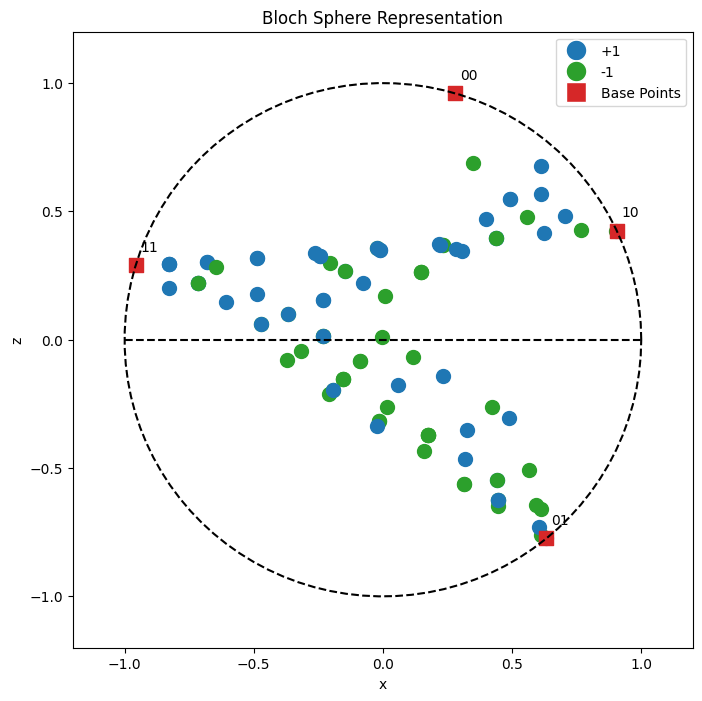

In [4]:
a = np.zeros((len(X), 2))
for i in range(len(X)):
    a[i] = get_bloch_coordinates(x= X[i], theta=theta)
fix_P = [[0, 0], [0, np.pi], [np.pi, 0], [np.pi, np.pi]]
a_base = np.zeros((len(fix_P), 2))
for i in range(len(fix_P)): 
    a_base[i] = get_bloch_coordinates(x= fix_P[i], theta=theta)

plot_bloch_sphere(a,y, a_base)